Imports
============

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
from dvn.data_utils import SyntheticData

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
torch.cuda.get_device_name(0)

'TITAN Xp'

Firstly we load the data
============


In [3]:
patch_size=64

train_synthetic = SyntheticData(root_path="./data/train/", patch_size=patch_size)
val_synthetic = SyntheticData(root_path="./data/val/", patch_size=patch_size)

print("DONE")

DONE


Visualize part of the data
============

In [4]:
print("Train size: %i" % len(train_synthetic))
print("Validation size: %i" % len(val_synthetic))
print("Img size: ", train_synthetic[0][0].size())
print("Segmentation size: ", train_synthetic[0][1].size())

Train size: 110
Validation size: 26
Img size:  torch.Size([1, 64, 64, 64])
Segmentation size:  torch.Size([64, 64, 64])


Design network 
============

In [5]:
train_loader = torch.utils.data.DataLoader(train_synthetic, batch_size=10, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_synthetic, batch_size=2, shuffle=False, num_workers=1)

Train network
============

In [6]:
model = DeepVesselNetFCN()
model.to(device)

optim_args_SGD = {"lr": 1e-2, "weight_decay": 0.01, "momentum": 0.9, "nesterov":True}
optim_args_ADAM = {"lr": 1e-2, "weight_decay": 0}

solver = Solver(optim_args=optim_args_SGD, optim=torch.optim.SGD)
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=15)

START TRAIN
[Iteration 5/165] TRAIN loss: -6.101
[Iteration 10/165] TRAIN loss: -7.613
[Epoch 1/15] TRAIN acc/loss/dice: 0.969/-7.613/0.787
[Epoch 1/15] VAL   acc/loss/dice: 0.023/-4.124/0.015
[Iteration 16/165] TRAIN loss: -7.785
[Iteration 21/165] TRAIN loss: -7.934
[Epoch 2/15] TRAIN acc/loss/dice: 0.993/-7.934/0.923
[Epoch 2/15] VAL   acc/loss/dice: 0.221/-4.729/0.181
[Iteration 27/165] TRAIN loss: -8.682
[Iteration 32/165] TRAIN loss: -8.353
[Epoch 3/15] TRAIN acc/loss/dice: 0.993/-8.353/0.917
[Epoch 3/15] VAL   acc/loss/dice: 0.990/-8.473/0.877
[Iteration 38/165] TRAIN loss: -8.458
[Iteration 43/165] TRAIN loss: -7.878
[Epoch 4/15] TRAIN acc/loss/dice: 0.987/-7.878/0.867
[Epoch 4/15] VAL   acc/loss/dice: 0.990/-8.486/0.880
[Iteration 49/165] TRAIN loss: -7.888
[Iteration 54/165] TRAIN loss: -7.911
[Epoch 5/15] TRAIN acc/loss/dice: 0.991/-7.911/0.881
[Epoch 5/15] VAL   acc/loss/dice: 0.997/-8.541/0.951
[Iteration 60/165] TRAIN loss: -9.043
[Iteration 65/165] TRAIN loss: -7.670
[Ep

Test network
============

Visualization of network outputs
============


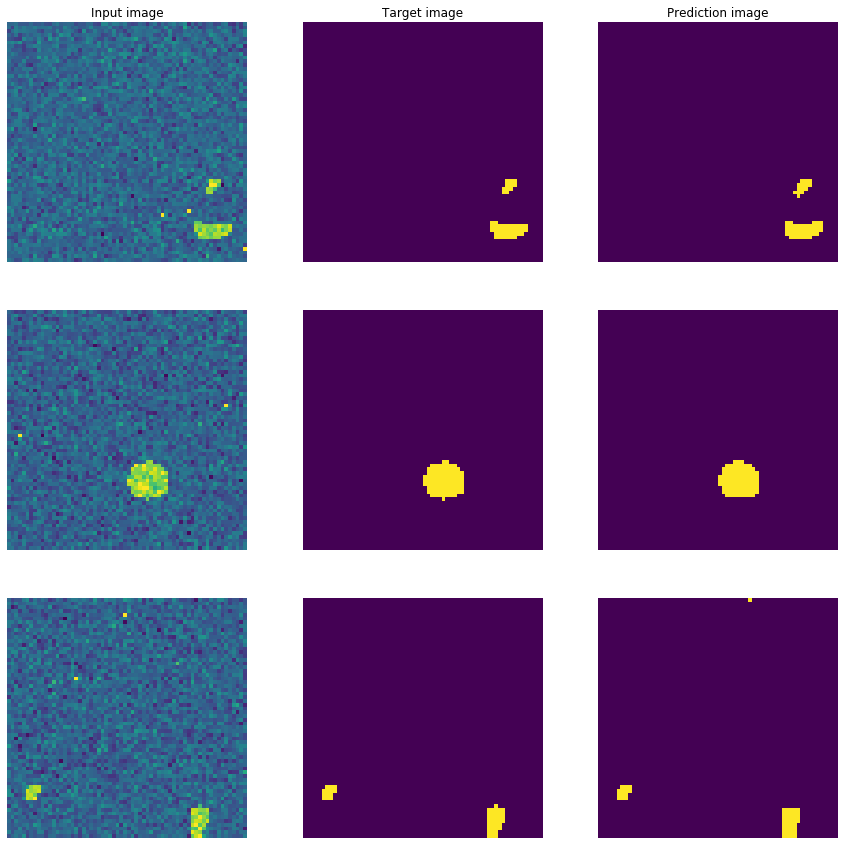

In [7]:
model = model.best_val_model
num_example_imgs = 3
plt.figure(figsize=(15, 5 * num_example_imgs))
model.eval()
for i, (inputs, targets) in enumerate(val_synthetic[:num_example_imgs]):
    
    inputs, targets = inputs.to(device, dtype=torch.float).unsqueeze(0), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)

    inputs, targets, preds = inputs.cpu().numpy(), targets.cpu().numpy(), preds.squeeze(0).cpu().numpy()
    
    # inputs
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(preds[5])
    if i == 0:
        plt.title("Prediction image")

Saving model... models/deepvesselnet4.model


/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DeepVesselNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked fo

Noisy data
============


In [3]:
patch_size=64

train_synthetic_noisy = SyntheticData(root_path="./noisy_data/train/", patch_size=patch_size)
val_synthetic_noisy = SyntheticData(root_path="./noisy_data/val/", patch_size=patch_size)

print("DONE")

train_noisy_loader = torch.utils.data.DataLoader(train_synthetic_noisy, 
                                                  batch_size=10, shuffle=True, num_workers=1)
val_noisy_loader = torch.utils.data.DataLoader(val_synthetic_noisy, 
                                                batch_size=2, shuffle=False, num_workers=1)

model_noisy = DeepVesselNetFCN(dropout=True)
model_noisy.to(device)

optim_args_SGD = {"lr": 1e-2, "weight_decay": 0, "momentum": 0.9, "nesterov":True}
optim_args_Adam = {"lr": 1e-2, "weight_decay": 0}

solver_noisy = Solver(optim_args=optim_args_SGD, optim=torch.optim.SGD)
solver_noisy.train(model_noisy, train_noisy_loader, val_noisy_loader, log_nth=5, num_epochs=10)

DONE
START TRAIN
[Iteration 5/110] TRAIN loss: -5.025
[Iteration 10/110] TRAIN loss: -5.800
[Epoch 1/10] TRAIN acc/loss/dice: 0.963/-5.800/0.584
[Epoch 1/10] VAL   acc/loss/dice: 0.066/-3.923/0.055
[Iteration 16/110] TRAIN loss: -7.000
[Iteration 21/110] TRAIN loss: -7.016
[Epoch 2/10] TRAIN acc/loss/dice: 0.953/-7.016/0.700
[Epoch 2/10] VAL   acc/loss/dice: 0.271/-4.536/0.468
[Iteration 27/110] TRAIN loss: -7.564
[Iteration 32/110] TRAIN loss: -7.522
[Epoch 3/10] TRAIN acc/loss/dice: 0.979/-7.522/0.804
[Epoch 3/10] VAL   acc/loss/dice: 0.964/-7.666/0.732
[Iteration 38/110] TRAIN loss: -8.727
[Iteration 43/110] TRAIN loss: -7.682
[Epoch 4/10] TRAIN acc/loss/dice: 0.974/-7.682/0.784
[Epoch 4/10] VAL   acc/loss/dice: 0.972/-7.618/0.790
[Iteration 49/110] TRAIN loss: -7.917
[Iteration 54/110] TRAIN loss: -7.772
[Epoch 5/10] TRAIN acc/loss/dice: 0.986/-7.772/0.871
[Epoch 5/10] VAL   acc/loss/dice: 0.703/-6.426/0.658
[Iteration 60/110] TRAIN loss: -7.648
[Iteration 65/110] TRAIN loss: -7.72

In [5]:
model_noisy = model_noisy.best_val_model
num_example_imgs = 5
plt.figure(figsize=(15, 5 * num_example_imgs))
model_noisy.eval()
for i, (inputs, targets) in enumerate(val_synthetic[:num_example_imgs]):
    
    inputs, targets = inputs.to(device, dtype=torch.float).unsqueeze(0), targets.to(device)
    
    outputs = model_noisy.forward(inputs)
    _, preds = torch.max(outputs, 1)

    inputs, targets, preds = inputs.cpu().numpy(), targets.cpu().numpy(), preds.squeeze(0).cpu().numpy()
    
    # inputs
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(preds[5])
    if i == 0:
        plt.title("Prediction image")


AttributeError: 'DeepVesselNetFCN' object has no attribute 'best_train_model'

## Save models

In [6]:
# Model trained on ideal synthetic dataset
os.makedirs("models", exist_ok=True)
model.save("models/deepvesselnet5.model")

# Model trained on noisy synthetic dataset
os.makedirs("models", exist_ok=True)
model_noisy.save("models/deepvesselnet_noisy1.model")

Saving model... models/deepvesselnet_noisy1.model


/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DeepVesselNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked fo